# GRAD CAM

## Import libraries

In [1]:
# Estas líneas de código nos permiten instalar opencv desde Jupyter Notebook, que vamos a necesitar para importar 'cv2'
import sys
!{sys.executable} -m pip install opencv-python --user

In [2]:
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install setuptools

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install --upgrade setuptools

Note: you may need to restart the kernel to use updated packages.


In [6]:
import tensorflow as tf
keras = tf.keras
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model, Model


import matplotlib.image as mpimg

## Load model

In [7]:
# Cargar tu modelo desde el archivo .h5
# model_path = './trained_model.h5'  # Ajusta esta ruta a donde está tu archivo .h5
model_path = './trained_model_2.keras'  # Ajusta esta ruta a donde está tu archivo .h5
model = load_model(model_path)

In [8]:
# Nombre de la última capa convolucional del modelo
last_conv_layer_name = 'conv_layer_2' 

## Model Summary

In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_layer_1 (Rescaling)         │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_1 (Conv2D)           │ (None, 100, 100, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_1_act (Activation)   │ (None, 100, 100, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_layer_1             │ (None, 50, 50, 8)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_2 (Conv2D)           │ (None, 50, 50, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_2_act (Activation)   │ (None, 50, 50, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_layer_2             │ (None, 25, 25, 8)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer_1 (Flatten)       │ (None, 5000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 128)            │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,923,584 (7.34 MB)

 Trainable params: 641,194 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,282,390 (4.89 MB)

## Inputs and Outputs

In [10]:
inputs = tf.keras.Input(name='mi_layer_input_1', shape=(100, 100, 3)) #KAPU
outputs = model(inputs)

In [11]:
model_output = model.output

## Check last conv layer

In [12]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [13]:
# Obtener la capa
last_conv_layer = model.get_layer(name=last_conv_layer_name)

print(last_conv_layer)

<Conv2D name=conv_layer_2, built=True>


In [14]:
model.inputs

[<KerasTensor shape=(None, 100, 100, 3), dtype=float32, sparse=False, name=input_layer>]

In [15]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [16]:
img_path = 'imagenes_todas/Parasitized/C33P1thinF_IMG_20150619_114756a_cell_179.png'
img_array = get_img_array(img_path, size=(100, 100))


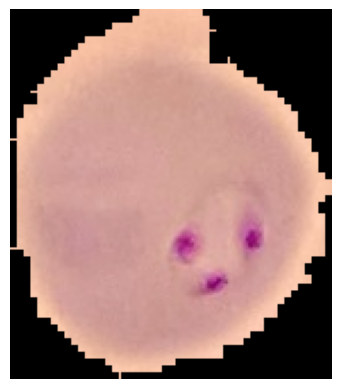

In [17]:
# Cargar y mostrar la imagen
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')  # Para ocultar los ejes
plt.show()

In [18]:
model(img_array)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[9.9999464e-01, 5.4136831e-06]], dtype=float32)>

In [19]:
model.layers

[<InputLayer name=input_layer, built=True>,
 <Rescaling name=res_layer_1, built=True>,
 <Conv2D name=conv_layer_1, built=True>,
 <Activation name=conv_layer_1_act, built=True>,
 <MaxPooling2D name=max_pooling_layer_1, built=True>,
 <Conv2D name=conv_layer_2, built=True>,
 <Activation name=conv_layer_2_act, built=True>,
 <MaxPooling2D name=max_pooling_layer_2, built=True>,
 <Flatten name=flatten_layer_1, built=True>,
 <Dense name=dense_layer_1, built=True>,
 <Dense name=output_layer, built=True>]

In [20]:
last_conv_layer_name

'conv_layer_2'

In [21]:
last_conv_layer

<Conv2D name=conv_layer_2, built=True>

In [22]:
last_conv_layer.output

<KerasTensor shape=(None, 50, 50, 8), dtype=float32, sparse=False, name=keras_tensor_9>

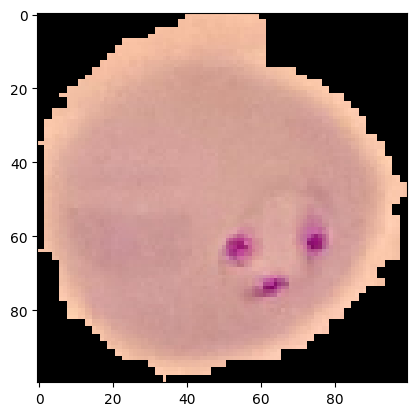

In [23]:
plt.imshow(img_array[0] / 255)

In [24]:
# Generate class activation heatmap
model.layers[-1].activation = None
preds = model.predict(img_array)
print(preds)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
[[ 6.4827666 -5.6438084]]


In [25]:
img_array

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]], dtype=float32)

In [26]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)


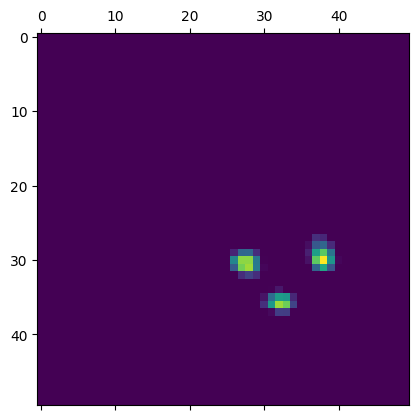

In [27]:
# Display heatmap
plt.matshow(heatmap)
plt.show()

## Superpose image w/ heatmap

In [ ]:
from tensorflow.keras.applications.imagenet_utils import decode_predictions



In [40]:
labels = ["Infectada", "No Infectada"]
labels[np.argmax(preds)]

'Infectada'

C:\Users\48521682\AppData\Local\Temp\ipykernel_12956\2962911379.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = plt.cm.get_cmap("jet")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2470588294898763].


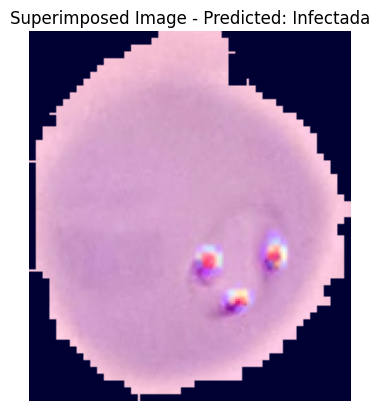

In [41]:
# Superpose the heatmap on original image

# Load the original image
img = keras.preprocessing.image.load_img(img_path)

# Rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# Use jet colormap to colorize heatmap
jet = plt.cm.get_cmap("jet")

# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]

# Create an image with RGB colorized heatmap
jet_heatmap = jet_colors[heatmap]

# Create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.size[0], img.size[1]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap) / 255

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + np.array(img) / 255

fig, ax = plt.subplots()

ax.imshow(superimposed_img)
ax.axis('off')
ax.set_title('Superimposed Image - Predicted: {}'.format(labels[np.argmax(preds)]))
plt.show()

In [43]:
def get_grad_heatmap(conv_layer_name):
    # Print what the top predicted class is
    preds = model.predict(img_array)
    print("Predicted:", labels[np.argmax(preds)])

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, conv_layer_name)


    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]

    # Create an image with RGB colorized heatmap
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.size[0], img.size[1]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap) / 255

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + np.array(img) / 255

    return superimposed_img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


C:\Users\48521682\AppData\Local\Temp\ipykernel_12956\1324231853.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = plt.cm.get_cmap("jet")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2305882554428251].


Predicted: Infectada
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.098823533338659].


Predicted: Infectada
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2470588294898763].


Predicted: Infectada
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted: Infectada


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.224313725677191].


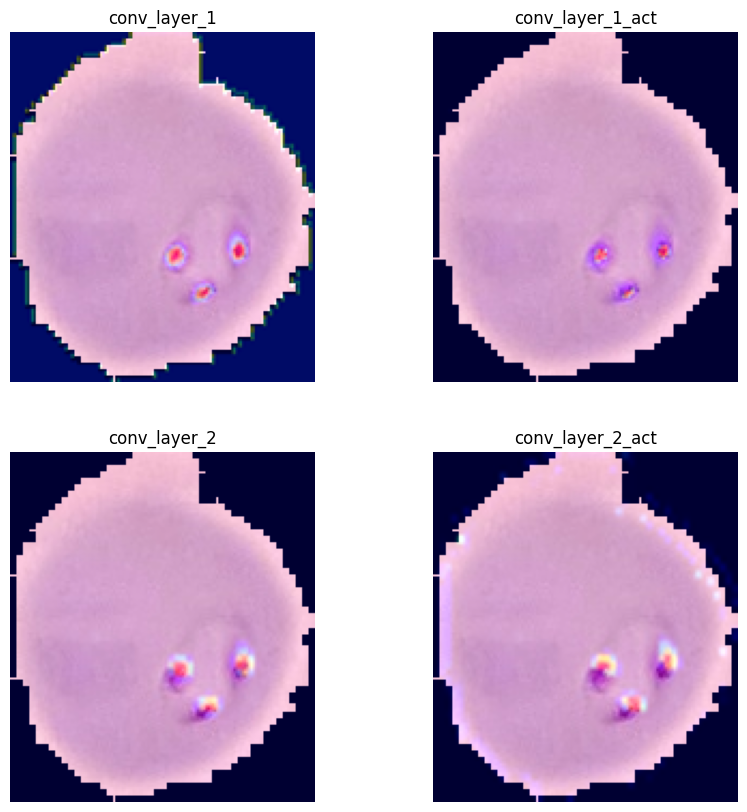

In [45]:
# Get all "*conv{n}_act" like layers in model
conv_layers = [layer.name for layer in model.layers if 'conv' in layer.name]
num_layers = len(conv_layers)

# Generar 16 índices únicos de manera uniforme
amm = 4
indices = np.linspace(0, num_layers - 1, amm, dtype=int)
fig, axes = plt.subplots(int(np.sqrt(amm)), int(np.sqrt(amm)), figsize=(10, 10))

for ax, i in zip(axes.flatten(), indices):
    heatmap = get_grad_heatmap(conv_layers[i])
    ax.imshow(heatmap)
    ax.axis('off')
    ax.set_title(conv_layers[i])